In [ ]:
#credits
https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
    https://www.bmc.com/blogs/python-spark-k-means-example/
- sampling: https://stackoverflow.com/questions/24806084/sampling-a-large-distributed-data-set-using-pyspark-spark
- filter pushing: https://engineering.dynatrace.com/blog/optimizing-spark-queries-with-filter-pushdown/
        -https://towardsdatascience.com/predicate-vs-projection-pushdown-in-spark-3-ac24c4d11855
            

In [1]:
!pip install pyspark



In [46]:
from pyspark.sql import SparkSession


In [47]:
import glob

In [48]:
pwd()

'D:\\Ethereum analysis - Copy'

In [49]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, TimestampType

In [50]:
from pyspark.sql import functions as F
#df.select(F.col("my_column"))

In [51]:
schema = StructType([ \
    StructField("sender",StringType(),True), \
    StructField("value",IntegerType(),True), \
    StructField("timestamp_in_unix_seconds",IntegerType(),True), \
    StructField("fee",IntegerType(),True), \
  ])

In [52]:
# spark.rdd.filter.csv.filterPushdown?
# spark config
from pyspark.conf import SparkConf


config = SparkConf().setAll([ \
    ('spark.executor.memory', '8g'), \
    ("spark.executor.instances", "4"), \

    ('spark.driver.memory','16g'), \
    ("spark.sql.parquet.filterPushdown", "true"), \
    ("spark.hadoop.parquet.filter.stats.enabled", "true"), \
    ("spark.sql.optimizer.nestedSchemaPruning.enabled", "true"), \
    ("spark.sql.optimizer.dynamicPartitionPruning.enabled", "true"), \
    ("spark.sql.autoBroadcastJoinThreshold", "-1"), \
    ("spark.sql.parquet.binaryAsString", "true") ]) \
#    ("spark.executor.memoryOverhead", "16384") \





In [53]:
print(config.setMaster("local").setAppName("Clustering using K-Means"))

print(config.get("spark.master"))

print(config.get("spark.app.name"))


local
Clustering using K-Means


In [54]:
import time

from datetime import datetime
spark = SparkSession.builder.appName("Clustering using K-Means") \
    .config(conf=config) \
    .getOrCreate() \
#    .option("failOnDataLoss", False)
#spark

In [55]:
spark

In [56]:
spark.sparkContext.getConf().getAll()

[('spark.master', 'local'),
 ('spark.executor.instances', '4'),
 ('spark.sql.parquet.binaryAsString', 'true'),
 ('spark.sql.parquet.filterPushdown', 'true'),
 ('spark.app.startTime', '1637856699594'),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1637856702506'),
 ('spark.sql.optimizer.dynamicPartitionPruning.enabled', 'true'),
 ('spark.driver.memory', '16g'),
 ('spark.driver.port', '55870'),
 ('spark.sql.optimizer.nestedSchemaPruning.enabled', 'true'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.hadoop.parquet.filter.stats.enabled', 'true'),
 ('spark.sql.autoBroadcastJoinThreshold', '-1'),
 ('spark.sql.warehouse.dir',
  'file:/D:/Ethereum%20analysis%20-%20Copy/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'Clustering using K-Means'),
 ('spark.driver.host', '10.0.7.40')]

In [60]:
# help received for reading several files: https://stackoverflow.com/questions/49898742/pandas-reading-csv-files-with-partial-wildcard

import glob
import os
BITCOIN_PATHS = sorted(glob.glob(os.path.join("D:\\Downloads\\ethereum\\", "ethereum*.csv")))
BITCOIN_PATHS

['D:\\Downloads\\ethereum\\ethereum000000000000.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000001.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000002.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000003.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000004.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000005.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000006.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000007.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000008.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000009.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000010.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000011.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000012.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000013.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000014.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000015.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000016.csv',
 'D:\\Downloads\\ethereum\\ethereum000000000017.csv',
 'D:\\Downloads\\ethereum\\e

In [61]:
# deal with date value (1): https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime
# deal with date value (2) :https://stackoverflow.com/questions/19801727/convert-datetime-to-unix-timestamp-and-convert-it-back-in-python
# hier wird dataframe gelesen. versuche es mit rdd .rdd()
data_customer=spark.read.csv(BITCOIN_PATHS, header=True, schema=schema) \
    .select("sender","value","fee") \
    .filter( \
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2017-12-18', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2018-12-16', '%Y-%m-%d').timetuple())))) |\
        ((F.col('timestamp_in_unix_seconds') >= int(time.mktime(datetime.strptime('2021-04-13', '%Y-%m-%d').timetuple()))) & (F.col('timestamp_in_unix_seconds') <= int(time.mktime(datetime.strptime('2021-07-20', '%Y-%m-%d').timetuple())))) \
            
           ) \
    .sample(False,0.01,1234) \
    .na.drop() \
    .persist()
data_customer.printSchema()

root
 |-- sender: string (nullable = true)
 |-- value: integer (nullable = true)
 |-- fee: integer (nullable = true)



In [62]:
data_customer.explain()

== Physical Plan ==
InMemoryTableScan [sender#6365, value#6366, fee#6368]
   +- InMemoryRelation [sender#6365, value#6366, fee#6368], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(1) Filter AtLeastNNulls(n, sender#6365,value#6366,fee#6368)
            +- *(1) Sample 0.0, 0.01, false, 1234
               +- *(1) Project [sender#6365, value#6366, fee#6368]
                  +- *(1) Filter (((timestamp_in_unix_seconds#6367 >= 1513551600) AND (timestamp_in_unix_seconds#6367 <= 1544914800)) OR ((timestamp_in_unix_seconds#6367 >= 1618264800) AND (timestamp_in_unix_seconds#6367 <= 1626732000)))
                     +- FileScan csv [sender#6365,value#6366,timestamp_in_unix_seconds#6367,fee#6368] Batched: false, DataFilters: [(((timestamp_in_unix_seconds#6367 >= 1513551600) AND (timestamp_in_unix_seconds#6367 <= 15449148..., Format: CSV, Location: InMemoryFileIndex[file:/D:/Downloads/ethereum/ethereum000000000000.csv, file:/D:/Downloads/ethere..., PartitionFilters: [], Push

In [63]:
data_customer.show(2)

+--------------------+-------+-----+
|              sender|  value|  fee|
+--------------------+-------+-----+
|0x13186e3b6cd3d71...|1000000|83823|
|0x4a170b4cab14d73...|   3000|21000|
+--------------------+-------+-----+
only showing top 2 rows



In [64]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
sqlContext.registerDataFrameAsTable(data_customer, "table1")
df2 = sqlContext.sql(" \
                     with counted_sender as (SELECT sender, count(*) as c \
                     from table1 group by sender) \
                     select table1.sender, avg(value) as avg_value, avg(fee) as avg_fee, c \
                     from table1 join counted_sender on table1.sender=counted_sender.sender \
                     group by table1.sender, c order by c desc"
                    )

In [65]:
# sender are filtered out, since they are hash values --> do not contain any structure
inputCols=['avg_value', 'avg_fee', 'c']


In [66]:
# transformation task. genau wie filter, join, etc. --> bis hier wird das aber nur vorbereitet
from pyspark.ml.feature import VectorAssembler
df2.columns
assemble=VectorAssembler(inputCols=inputCols, outputCol='features')
assembled_data=assemble.transform(df2)
assembled_data.show(2)

+--------------------+---------+-------+---+--------------------+
|              sender|avg_value|avg_fee|  c|            features|
+--------------------+---------+-------+---+--------------------+
|0x28b1b89ab7c32c5...|    1.0E9|64213.0| 17|[1.0E9,64213.0,17.0]|
|0xea1baa460795356...|      1.0|21000.0| 16|  [1.0,21000.0,16.0]|
+--------------------+---------+-------+---+--------------------+
only showing top 2 rows



In [67]:
# an dieser stelle findet erstmals eine aktion statt. die vorbereiteten transformationen werden durchgeführt.
#standarizer
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized', withMean=True, withStd=True)
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+--------------------+---------+-------+---+--------------------+--------------------+
|              sender|avg_value|avg_fee|  c|            features|        standardized|
+--------------------+---------+-------+---+--------------------+--------------------+
|0x28b1b89ab7c32c5...|    1.0E9|64213.0| 17|[1.0E9,64213.0,17.0]|[2.82005472060955...|
|0xea1baa460795356...|      1.0|21000.0| 16|  [1.0,21000.0,16.0]|[-0.3557050856352...|
+--------------------+---------+-------+---+--------------------+--------------------+
only showing top 2 rows



In [68]:
#from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol="standardized")
pca.setOutputCol("pca_features")
model = pca.fit(data_scale_output)
data_scale_output = model.transform(data_scale_output)

In [69]:
data_scale_output.show(2)

+--------------------+---------+-------+---+--------------------+--------------------+--------------------+
|              sender|avg_value|avg_fee|  c|            features|        standardized|        pca_features|
+--------------------+---------+-------+---+--------------------+--------------------+--------------------+
|0x28b1b89ab7c32c5...|    1.0E9|64213.0| 17|[1.0E9,64213.0,17.0]|[2.82005472060955...|[-10.651152736796...|
|0xea1baa460795356...|      1.0|21000.0| 16|  [1.0,21000.0,16.0]|[-0.3557050856352...|[-7.8688198038013...|
+--------------------+---------+-------+---+--------------------+--------------------+--------------------+
only showing top 2 rows



In [70]:
# variance explained
model.explainedVariance

DenseVector([0.3694, 0.3301, 0.3004])

In [72]:
# help received from: https://stackoverflow.com/questions/59883306/how-to-drop-a-column-from-a-spark-dataframe-by-index-where-column-names-can-be-d
# pca plot variance explained https://datascience-enthusiast.com/Python/PCA_Spark_Python_R

import numpy as np
import pandas as pd
pcs = np.round(model.pc.toArray(),4)
df_pc = pd.DataFrame(pcs, columns = ['PC'+str(i) for i in range(1, 4)], index = inputCols)
df_pc


,PC1,PC2,PC3
avg_value,-0.6894,0.0623,-0.7217
avg_fee,-0.3771,-0.8815,0.2842
c,-0.6185,0.4681,0.6312


In [74]:
%%time
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i, seed=1) # set seed
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.9372109173172476
Silhouette Score: 0.843710152558556
Silhouette Score: 0.8982503349339863
Silhouette Score: 0.934017073207804
Silhouette Score: 0.9232885886246384
Silhouette Score: 0.9228496839386349
Silhouette Score: 0.9248666077885384
Silhouette Score: 0.9200819856423744
Wall time: 42min 41s


Text(0, 0.5, 'silhouette score')

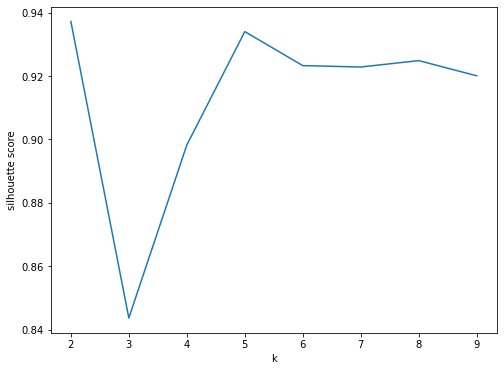

In [75]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("silhouette score")

In [76]:



from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans(featuresCol='standardized').setK(4).setSeed(1)
model = kmeans.fit(data_scale_output)

# Make predictions
predictions = model.transform(data_scale_output)




In [79]:
# output of transform "output" or "predictions"
pandasDF=predictions.toPandas()

In [81]:
import pandas as pd
centers = pd.DataFrame(ctr,columns=inputCols)
centers # könnte man einzeichnen, wenn man plot mit skalierten daten (nicht pca -daten) macht
#  centers of the 4 clusters, by viewing the dimensions avg_value_avg_fee and c

,avg_value,avg_fee,c
0,-0.301047,-0.042156,-0.101039
1,0.702882,14.729673,0.125570
2,-0.031529,-0.233414,10.261796
3,2.972044,0.083345,0.178350


In [82]:
# plot pca
#pca_pandas = pandasDF.toPandas()
x = []
y = []
z = []
for i, j, k in pandasDF["pca_features"].values:
    x.append(i)
    y.append(j)
    z.append(k)

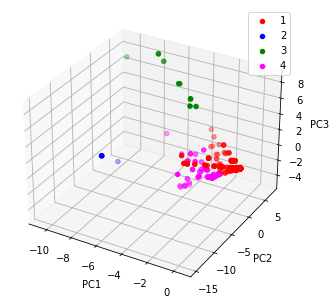

In [83]:
# help: u.a. https://stackoverflow.com/questions/37711538/matplotlib-3d-axes-ticks-labels-and-latex
# todo change size:https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled bitcoin transaction avg_value
scatter_y = np.array(y) # scaled bitcoin transaction avg_fee
scatter_z = np.array(z) # scaled bitcoin transaction count
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'magenta'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [84]:
# bring scaled values(value, fee) into list
# 3 gegeben durch anzahl columns (nicht anzahl clusters nach kmeans)
x = []
y = []
z = []
for i, j, k in pandasDF["standardized"].values:
    x.append(i)
    y.append(j)
    z.append(k)

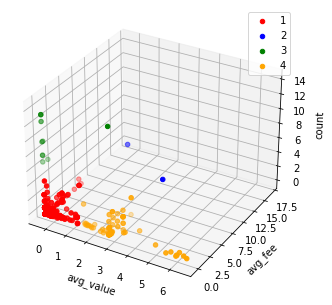

In [85]:
# help: u.a. https://stackoverflow.com/questions/37711538/matplotlib-3d-axes-ticks-labels-and-latex

import matplotlib.pyplot as plt

# plot mit scaled daten: value vs. fee
#todo: outlier entfernen
#todo: mean centers rein tun
import numpy as np
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
scatter_x = np.array(x) # scaled bitcoin transaction avg_value
scatter_y = np.array(y) # scaled bitcoin transaction avg_fee
scatter_z = np.array(z) # scaled bitcoin transaction count
group = np.array(pandasDF['prediction'])

cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
#fig, ax = plt.subplots()
fig = pyplot.figure()
ax = Axes3D(fig)
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], scatter_z[ix], c = cdict[g], label = g+1)
ax.legend()
plt.xlabel("avg_value")
plt.ylabel("avg_fee")
ax.set_zlabel("count")
plt.show()

#plt.scatter(y=pandasDF["fee"],x=pandasDF["value"], c=pandasDF["prediction"], cmap='brg')
#plt.legend()

#plt.scatter(y=y,x=x, c=pandasDF["prediction"].values, cmap='brg')
#plt.legend()

